In [6]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import os
import cv2
import glob
import numpy as np
np.random.seed(1337)
import sys
from tensorflow.keras.layers import GlobalAveragePooling2D
import dlib
import random
from keras.models import Sequential
from __future__ import print_function
from keras.preprocessing import image
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import curses
from __future__ import print_function
from keras.regularizers import l2
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [4]:
!pip install keras_vggface

In [2]:
!pip install Keras-Applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 674.0 kB/s eta 0:00:00


In [7]:

class Vocabulary(object):
    ''' A two-way mapping between words in our vocabulary and indexes. This
        means that one can look up a word by index or an index by word. '''
    def __init__(self, words):
        # Mapping of words to indices.
        self.word_to_index_map = {}

        # Mapping of indices to words.
        self.index_to_word_map = {}

        # Mapping of words to number of occurrences.
        self.occurrences_map = {}

        word_set = set(words)

        for index, word in enumerate(word_set):
            self.word_to_index_map[word] = index
            self.index_to_word_map[index] = word
            self.occurrences_map[word] = 0

        for word in words:
            self.occurrences_map[word] += 1

        self.total = len(words)
        self.length = len(word_set)


    def __len__(self):
        return self.length


    def __getitem__(self, key):
        try:
            return self.index_to_word_map[key]
        except KeyError:
            return self.word_to_index_map[key]


    def occurrences(self, word=None):
        if word:
            return self.occurrences_map[word]
        else:
            return self.occurrences_map

In [8]:

VIDEO_DIRECTORY_PATH = '/content/drive/MyDrive/data_new/videos'
ALIGN_DIRECTORY_PATH = '/content/drive/MyDrive/data_new/alignment'
FEATURE_DIRECTORY_PATH = '/content/drive/MyDrive/data_new/features'

DEFAULT_TRAINING_FRACTION = 0.7

NUM_FRAMES = 6

NUM_FACIAL_FEATURES = 512

def alignment_function(fp):
    ''' Parse alignment data for an align file. '''
    with open(fp, 'r') as f:
        lines = f.readlines()

    segments = []
    for line in lines:
        words = line.split()

        # Round the start frame down and end frame up.
        start = int(round(float(words[0]) / 1000))
        end = int(round(float(words[1]) / 1000))

        segments.append((start, end, words[2]))

    num_frames = segments[-1][1] - segments[0][0]
    # exclude first and last (cause it's sil)
    return segments[1:-1], num_frames


def video_function(speaker, vid_name):
    ''' Split a video into sets of frames corresponding to each spoken word. '''
    video_path = os.path.join(VIDEO_DIRECTORY_PATH, speaker, vid_name)
    align_name = vid_name.split('.')[0] + '.align'
    align_path = os.path.join(ALIGN_DIRECTORY_PATH, speaker, align_name)

    cap = cv2.VideoCapture(video_path)
    alignments, num_frames = alignment_function(align_path)

    frames = np.ndarray(shape=(num_frames, 224, 224, 3), dtype=np.float32)

    frame = 0
    ret, img = cap.read()

    while ret:
        x = cv2.resize(img, (224, 224)).astype(np.float32)

        x = np.expand_dims(x, axis=0)

        x[:, :, :, 0] -= 93.5940
        x[:, :, :, 1] -= 104.7624
        x[:, :, :, 2] -= 129.1863

        frames[frame,:,:,:] = x

        ret, img = cap.read()

        frame += 1
        if(frame==74):
          break

    # Divide up frames based on mapping to spoken words.
    word_frames = []
    output = []
    for seg in alignments:
        word_frames.append(frames[seg[0]:seg[1],:,:])
        output.append(seg[2])

    return word_frames, output


def vocab_function(words):
    ''' Build vocabulary and use it to format labels. '''
    vocab = Vocabulary(words)

    # Map words to word embedding vectors.
    output_vector = []
    for word in words:
        zeros = np.zeros(len(vocab), dtype=np.float32)
        zeros[vocab[word]] = 1.0

        output_vector.append(zeros)

    return vocab, output_vector


def tfold(x, y, k):
    ''' Split testing and training data k ways to enable k-fold
        cross-validation. '''
    interval = int(x.shape[0] / k)

    masks = []
    for i in range(1, k):
        # Create mask for testing section of data.
        test_mask = np.zeros(x.shape[0], dtype=bool)
        test_mask[(i-1)*interval:i*interval] = True

        masks.append(test_mask)

    x_test = x[-interval:, ...]
    y_test = y[-interval:, ...]
    masks.append(test_mask)

    return masks


def split_train_test(x, y, test_mask):
    x_train = x[~test_mask, ...]
    y_train = y[~test_mask, ...]
    train = (x_train, y_train)

    x_test = x[test_mask, ...]
    y_test = y[test_mask, ...]
    test = (x_test, y_test)

    return train, test


def process_frames(frames, desired_length):
    ''' Condense a set of frames down to a desired length by averaging
        neighbouring frames. '''

    # Already at or below desired length, nothing to be done.
    if len(frames) <= desired_length:
        return frames

    # We need to get one frame from every cond_ratio frames.
    cond_ratio = len(frames) * 1.0 / desired_length

    condensed_frames = np.zeros((desired_length, frames.shape[1]), dtype=frames.dtype)

    frame_count = 0.0

    for i in range(desired_length):
        idx = int(frame_count)
        end_idx = idx + 1
        weights = [idx + 1 - frame_count]

        # Frames that are contributing fully to this average have a weight of 1.
        while cond_ratio - sum(weights) >= 1.0:
            weights.append(1.0)
            end_idx += 1

        # Account for any remainder.
        if cond_ratio > sum(weights) + 0.0000001:
            weights.append(cond_ratio - sum(weights))
            end_idx += 1

        # Normalize the weights.
        norm = np.linalg.norm(weights)
        weights = [w / norm for w in weights]

        condensed_frames[i,:] = np.average(frames[idx:end_idx,:], axis=0, weights=weights)

        frame_count += cond_ratio

    return condensed_frames


def shuffle_data(x, y):
    ''' Shuffle the features and labels into a random order. '''
    r = list(range(len(x)))
    np.random.shuffle(r)

    xr = []
    yr = []

    for i in range(1,len(x)):
        idx = r[i]
        xr.append(x[idx])
        yr.append(y[idx])

    return xr, yr


def files_load(data_files, shuffle):
    ''' Load specified data files into feature and label arrays. '''
    x = [] # Features
    y = [] # Labels
    empty_file_count = 0

    for data_file in data_files:
        name_no_ext = os.path.basename(data_file).split('.')[0]
        word = name_no_ext.split('_')[2]

        data = np.load(data_file)

        if data.shape[0] == 0:
            empty_file_count += 1
            continue

        # 'sp' denotes a pause in speaking. We do not want to treat this as a
        # word.
        if word == 'sp':
            continue

        x.append(data[:,:NUM_FACIAL_FEATURES])
        y.append(word)

    if shuffle:
        x, y = shuffle_data(x, y)

    return x, y, empty_file_count


def max_frames(features):
    ''' Calculate the maximum number of frames any word has. '''
    max_frames = 0
    for f in features:
        if f.shape[0] > max_frames:
            max_frames = f.shape[0]
    return max_frames


def Normalize(word_frame):
    ''' Normalize so all values in the set of frames for the word add to one. '''
    norm = np.linalg.norm(word_frame)
    if norm == 0:
        # If the norm is zero, meaning the vector is zero, we just use
        # an evenly distributed unit array.
        ones = np.ones(word_frame.shape)
        return ones / np.linalg.norm(ones)
    return word_frame / norm


def load_data(k=5, speakers=[], shuffle=False, use_delta_frames=True):

    if len(speakers) == 0:
        data_glob = os.path.join(FEATURE_DIRECTORY_PATH, '*', '*.npy')
        data_files = glob.glob(data_glob)
    else:
        data_files = []
        for speaker in speakers:
            speaker = 's' + str(speaker)
            data_glob = os.path.join(FEATURE_DIRECTORY_PATH, speaker, '*.npy')
            data_files.extend(glob.glob(data_glob))

    x, y, empty_file_count = files_load(data_files, shuffle)
    print('Skipped {} empty data files.'.format(empty_file_count))

    # Build mapping of vocabulary to integers, and remap output to it.
    vocab, y = vocab_function(y)


    word_max_frames = max_frames(x)
    if use_delta_frames:
        effective_num_frames = NUM_FRAMES + 1
    else:
        effective_num_frames = NUM_FRAMES

    for i, f in enumerate(x):
        last = np.array(f[-1].reshape(1, NUM_FACIAL_FEATURES))

        # Add padding with duplicates of last frame.
        for _ in range(f.shape[0], effective_num_frames):
            x[i] = np.concatenate((x[i], last), axis=0)

        x[i] = process_frames(x[i], effective_num_frames)

        if use_delta_frames:
            # Take deltas.
            for j in range(1, len(x[i])):
                x[i][j-1,:] = x[i][j,:] - x[i][j-1,:]

            # Remove extra frame from the end.
            x[i] = x[i][:NUM_FRAMES, ...]

        # Normalize the entire set of frames for this word.
        x[i] = Normalize(x[i])

    x = np.asarray(x)
    y = np.asarray(y)
    kmasks = tfold(x, y, k)

    return x, y, kmasks, vocab


def main(speaker):
    ''' Progressively convert video data into facial feature data and save it. '''

    input_tensor = Input(shape=(224, 224, 3))
    vgg_model = VGGFace(input_tensor=input_tensor, include_top=False, pooling='avg')

    speaker_feature_dir = os.path.join(FEATURE_DIRECTORY_PATH, speaker)
    if not os.path.isdir(speaker_feature_dir):
        os.mkdir(speaker_feature_dir)

    video_glob = os.path.join(VIDEO_DIRECTORY_PATH, speaker, '*.mpg')
    video_paths = glob.glob(video_glob)
    num_videos = len(video_paths)
    word_count = 0

    try:
        for video_count, video_path in enumerate(video_paths):
            video_name = os.path.basename(video_path)
            word_frames, output = video_function(speaker, video_name)

            name_no_ext = video_name.split('.')[0]
            for i, word_frame in enumerate(word_frames):

                word_count += 1
                feature_file_name = '{}_{}_{}'.format(name_no_ext, i, output[i])
                feature_file_path = os.path.join(speaker_feature_dir, feature_file_name)
                if os.path.isfile(feature_file_path + '.npy'):
                    continue
                tf.config.run_functions_eagerly(True)

                features = vgg_model.predict(word_frame)
                np.save(feature_file_path, features)
    except (SystemExit, KeyboardInterrupt):

        pass

In [9]:
x, y, kmasks, vocab = load_data(k=5,speakers=[1,2,3,4,5,6,7,10,11,20],shuffle=True, use_delta_frames=True)

Skipped 0 empty data files.


In [10]:
vocab.occurrences().keys

<function dict.keys>

In [11]:
FOLD = 0

train, test = split_train_test(x, y, kmasks[FOLD])
print(len(x))
print(len(y))

x_train, y_train = train
x_test, y_test = test

print('Number of words for training: ', x_train.shape[0])
print('Number of words for testing: ', x_test.shape[0])
print('Frames per word: ', x_train.shape[1])
print('Features per frame: ', x_train.shape[2])

5665
5665
Number of words for training:  4532
Number of words for testing:  1133
Frames per word:  6
Features per frame:  512


In [12]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
X_train = (x_train - mean) / std
X_val = (x_test - mean) / std

In [13]:
model = Sequential()

model.add(LSTM(128, input_shape=x_train[0].shape, return_sequences=True,kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(64,kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(len(vocab), activation='softmax'))


In [14]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [15]:
schedule_callback = LearningRateScheduler(scheduler)

In [16]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [24]:
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=2)

In [25]:
model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])

In [26]:
history=model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=1, validation_data=(x_test, y_test),callbacks=[ reduce_lr,checkpoint_callback,schedule_callback])

Epoch 1/50
71/71 [==============================] - 12s 72ms/step - loss: 1.0829 - accuracy: 0.7776 - val_loss: 2.3888 - val_accuracy: 0.5649 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 3s 49ms/step - loss: 1.0021 - accuracy: 0.8169 - val_loss: 2.3051 - val_accuracy: 0.5702 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 4s 61ms/step - loss: 1.0296 - accuracy: 0.7992 - val_loss: 2.2299 - val_accuracy: 0.6117 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 5s 71ms/step - loss: 1.0269 - accuracy: 0.8118 - val_loss: 2.2435 - val_accuracy: 0.5719 - lr: 0.0010
Epoch 5/50
71/71 [==============================] - 4s 52ms/step - loss: 1.0218 - accuracy: 0.8127 - val_loss: 2.1250 - val_accuracy: 0.6011 - lr: 0.0010
Epoch 6/50
71/71 [==============================] - 3s 48ms/step - loss: 1.0102 - accuracy: 0.8202 - val_loss: 2.5882 - val_accuracy: 0.5428 - lr: 0.0010
Epoch 7/50
71/71 [==============================] - 6s 79ms/step - loss: 1.

In [27]:
score, acc = model.evaluate(x_test, y_test, batch_size=64)
print('Test score: ', score)
print('Test accuracy: ', acc)

18/18 [==============================] - 0s 18ms/step - loss: 1.6890 - accuracy: 0.6646
Test score:  1.6889575719833374
Test accuracy:  0.6646072268486023


In [28]:
frames_per_word = x_test.shape[1]
features_per_frame = x_test.shape[2]

RESULTS_TO_CHECK = 50
MATCHES_PER_WORD = 4

for i in range(RESULTS_TO_CHECK):
    pred = model.predict(x_test[i].reshape(1, frames_per_word, features_per_frame))
    predicted_indexes = np.argsort(pred.reshape(len(vocab)))[::-1][:MATCHES_PER_WORD]
    correct_index = np.argsort(y_test[i])[::-1][0]

    correct_word = vocab[correct_index]
    predicted_words = [vocab[i] for i in predicted_indexes]

    best_match = None
    for word in predicted_words:
        if word == correct_word:
            best_match = word
            break

    if best_match is not None:
        print('{} : {}'.format(correct_word, best_match))
    else:
        print('{} : {}'.format(correct_word, predicted_words[0]))

1/1 [==============================] - 1s 1s/step
two : two
1/1 [==============================] - 0s 47ms/step
f : green
1/1 [==============================] - 0s 47ms/step
with : with
1/1 [==============================] - 0s 44ms/step
blue : blue
1/1 [==============================] - 0s 39ms/step
again : again
1/1 [==============================] - 0s 45ms/step
with : with
1/1 [==============================] - 0s 43ms/step
five : five
1/1 [==============================] - 0s 43ms/step
now : now
1/1 [==============================] - 0s 42ms/step
white : white
1/1 [==============================] - 0s 41ms/step
now : now
1/1 [==============================] - 0s 47ms/step
two : two
1/1 [==============================] - 0s 38ms/step
g : u
1/1 [==============================] - 0s 49ms/step
now : now
1/1 [==============================] - 0s 39ms/step
again : again
1/1 [==============================] - 0s 37ms/step
five : five
1/1 [==============================] - 0s 44ms/step
no

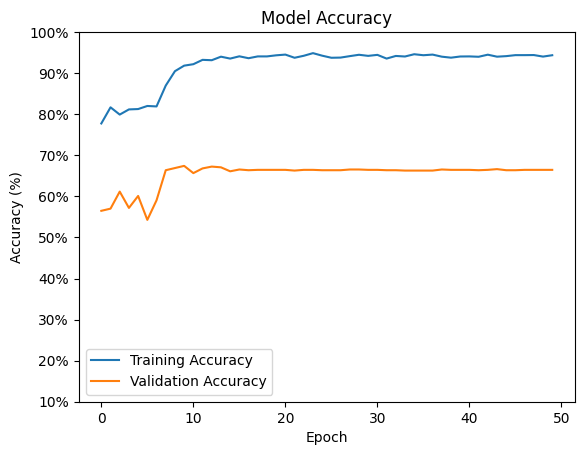

In [29]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

# Set the y-axis ticks to start from 10% and in 1% intervals
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
plt.ylim(0.1, 1.0)  # Set the y-axis limits from 10% to 100%

plt.legend()
plt.show()
